In [1]:
from pymatgen import MPRester, Element, Composition
from pymatgen.phasediagram.maker import PhaseDiagram
from pymatgen.phasediagram.entries import PDEntry
from pymatgen.phasediagram.analyzer import PDAnalyzer
from pymatgen.analysis.reaction_calculator import ComputedReaction
import matplotlib.pyplot as plt
import sys

In [124]:
def get_chempots_phases_enthalpies(chsys, formula, elem):
    chempots = [] #critical chemical potentials at every transition point
    evolutions = [] 
    phases = []
    enthalpies = []
    reactions = []
    yvec = []
    
    exclusion_list = ['LiS4','S8O']
    with MPRester() as m:
        entries = m.get_entries_in_chemsys(chsys)
        mpentry = m.get_entries(formula) #gets all MP-entries associated with given composition
    
    entries = [e for e in entries if e.name not in exclusion_list]
    comp_entry = Composition(formula)
    pd = PhaseDiagram(entries)
    pda = PDAnalyzer(pd)
    evolution_profile = pda.get_element_profile(Element(elem), comp_entry)
    ref = evolution_profile[0]['element_reference'].energy_per_atom
    
    if len(mpentry) == 0: #composition is metastable, so force it to lie on the convex hull
        compound = PDEntry(Composition(formula), 0)
        e0 = pda.get_e_above_hull(compound)
        compound = PDEntry(Composition(formula), -(e0/comp_entry.num_atoms))
    else: #otherwise return the most stable entry in the list of MP-entries. This entry can be metastable.
            #in the future, may want to include a shift of "e-above-hull" to set this compound on the x-axis
        mpentry = sorted(mpentry, key=lambda e: e.energy_per_atom)
        compound = mpentry[0]
    
    reac = [compound]
    reac.append(evolution_profile[0]['element_reference'])
    
    for stage in evolution_profile:
        chempots.append(stage['chempot'] - ref)
        evolutions.append(stage['evolution'])
        namelist = []
        for entry in stage['entries']:
            namelist.append(entry.name)
        phases.append(namelist)
    
    yshift = 0  #initialize y-shift
    window = False #assume the compound has no stability window at first
    for stage in evolution_profile:
        rxn = ComputedReaction(reac, stage['entries']) #calculate reaction enthalpy
        rxn.normalize_to(Composition(compound.name))
        enthalpies.append(rxn.calculated_reaction_energy)
        reactions.append(str(rxn))
        if abs(stage['evolution']) < 0.0001: #the compound has a stability window
            window = True
            yshift = stage['evolution']*stage['chempot'] + rxn.calculated_reaction_energy
    
    if not window: #if there is no stability window, check if it is metastable
        ehull = pda.get_e_above_hull(compound)
        if ehull > 0: #the compound is metastable
            yshift = -(ehull*comp_entry.num_atoms) #set y-shift to the e above hull for the formula unit
            
    for i in range(len(chempots)): #manipulate and shift data for graphs
        ynew = (evolutions[i]*(-chempots[i]) + enthalpies[i]) - yshift
        yvec.append(ynew)            
    
    return [chempots, phases, yvec, enthalpies, reactions]

In [107]:
from pymatgen.phasediagram.plotter import PDPlotter
def get_eligible_reactions(chsys, formula, elem):
    enthalpies = []
    reactions = []
    
    exclusion_list = ['LiS4','S8O']
    cutoff = 0.1 # energy of cutoff in eV
    
    with MPRester() as m:
        entries = m.get_entries_in_chemsys(chsys)
        mpentry = m.get_entries(formula) #gets all MP-entries associated with given composition
    
    entries = [e for e in entries if e.name not in exclusion_list]
    
    comp_entry = Composition(formula)
    pd = PhaseDiagram(entries)
    pda = PDAnalyzer(pd)
    evolution_profile = pda.get_element_profile(Element(elem), comp_entry)
    ref = evolution_profile[0]['element_reference']
    
    mpentry = sorted(mpentry, key=lambda e: e.energy_per_atom)
    compound = mpentry[0]
    
    filtered_entries = []
    filtered_names = []
    for e in entries:
        ehull = pda.get_e_above_hull(e)
        if ehull == 0:
            filtered_entries.append(e)
            filtered_names.append(e.name)
    for e in entries:
        ehull = pda.get_e_above_hull(e)
        if e.name not in filtered_names and ehull < cutoff:
            filtered_entries.append(e)
        
    reac = [compound]
    reac.append(ref)
    
    for stage in evolution_profile:
        rxn = ComputedReaction(reac, stage['entries']) #calculate reaction enthalpy
        rxn.normalize_to(Composition(ref.name))
        reactions.append(str(rxn))
        enthalpies.append(rxn.calculated_reaction_energy)
    
    for x in range(2,4):
        rxn = ComputedReaction(reac, [filtered_entries[x], filtered_entries[4]])
        rxn.normalize_to(Composition(ref.name))
        reactions.append(str(rxn))
        enthalpies.append(rxn.calculated_reaction_energy)

    pd = PhaseDiagram(filtered_entries)
    plotter = PDPlotter(pd, show_unstable=True)
    plotter.show()
    
    return [reactions, enthalpies]

2
3


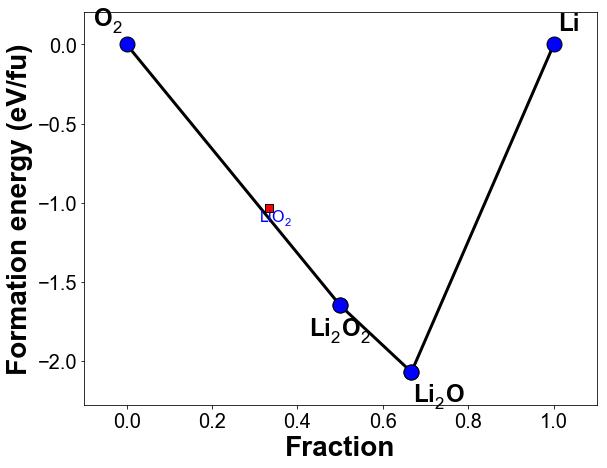

In [105]:
Li_el = get_eligible_reactions(['Li','O'],'Li','O')

In [114]:
pnds.options.display.float_format = '{:.3f}'.format
table1 = pnds.DataFrame({'Reaction':Li_el[0], 
                         r'$\Delta H_{rxn}$ per $O_2$':Li_el[1]})
table1 = table1[['Reaction',r'$\Delta H_{rxn}$ per $O_2$']]
display(table1)

,Reaction,$\Delta H_{rxn}$ per $O_2$
0,O2 + 2 Li -> Li2O2,-6.600
1,O2 + 4 Li -> 2 Li2O,-12.426
2,inf Li -> inf Li,nan
3,O2 + 2 Li -> 0.6667 LiO2 + 0.6667 Li2O,-6.208
4,O2 + 1.5 Li -> 0.5 LiO2 + 0.5 Li2O2,-4.850


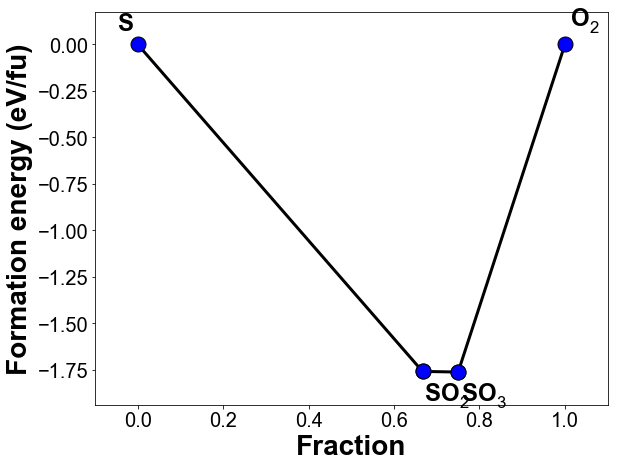

In [112]:
S_el = get_eligible_reactions(['S','O'],'S','O')

In [113]:
table1 = pnds.DataFrame({'Reaction':S_el[0], 
                         r'$\Delta H_{rxn}$ per $O_2$':S_el[1]})

table1 = table1[['Reaction', r'$\Delta H_{rxn}$ per $O_2$']]

display(table1)

,Reaction,$\Delta H_{rxn}$ per $O_2$
0,0.6667 S + O2 -> 0.6667 SO3,-4.696
1,S + O2 -> SO2,-5.273
2,inf S -> inf S,nan


In [11]:
%matplotlib inline

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib.patches as patches

# mpl.rcdefaults()

f_size = 14
mpl.rcParams['xtick.labelsize']=f_size
mpl.rcParams['ytick.labelsize']=f_size
mpl.rcParams['axes.labelweight']='light'
mpl.rcParams['axes.labelsize']=f_size
mpl.rcParams['font.size']=f_size
mpl.rcParams['font.family']='sans-serif'
mpl.rcParams['font.sans-serif']='Arial'
mpl.rcParams['font.style']='normal'
mpl.rcParams['font.weight']='light'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams["figure.figsize"] = (8,5)

import pandas as pnds

In [30]:
S_cpe = get_chempots_phases_enthalpies(['S','O'],'S','O')
Li_cpe = get_chempots_phases_enthalpies(['Li','O'],'Li','O')

In [132]:
pnds.options.display.float_format = '{:.3f}'.format

table1 = pnds.DataFrame({r'$\mu_O$ (eV)':S_cpe[0],
                      'Phase Equilibria':S_cpe[1],
                     r'$\Delta H$ per S (eV/atom)':S_cpe[3],
                        'Reaction':S_cpe[4]})

table1 = table1[['Reaction','Phase Equilibria',r'$\mu_O$ (eV)',r'$\Delta H$ per S (eV/atom)']]
table2 = pnds.DataFrame({r'$\mu_O$ (eV)':Li_cpe[0],
                      'Phase Equilibria':Li_cpe[1],
                     r'Rxn Energy (eV/atom)':Li_cpe[3],
                        'Reaction':Li_cpe[4]})

display(table1)
display(table2)

,Reaction,Phase Equilibria,$\mu_O$ (eV),$\Delta H$ per S (eV/atom)
0,S + 1.5 O2 -> SO3,[SO3],0.000,-7.044
1,S + O2 -> SO2,[SO2],-1.771,-5.273
2,S -> S,[S],-2.636,0.000


,$\mu_O$ (eV),Phase Equilibria,Reaction,Rxn Energy (eV/atom)
0,0.000,[Li2O2],0.5 O2 + Li -> 0.5 Li2O2,-3.300
1,-0.387,[Li2O],0.25 O2 + Li -> 0.5 Li2O,-3.106
2,-6.213,[Li],Li -> Li,0.000


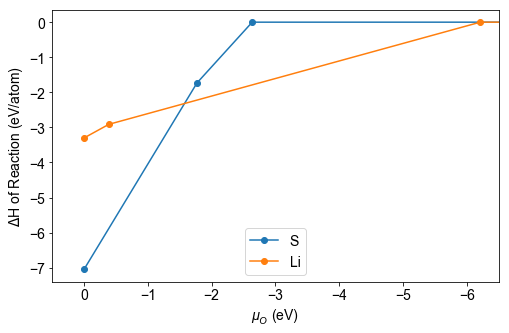

In [134]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot((S_cpe[0] + [-10]), (S_cpe[2] + [S_cpe[2][-1]]), 'o', ls='-', label= r'S')
p2 = plt.plot(Li_cpe[0] + [-10], Li_cpe[2] + [S_cpe[2][-1]], 'o', ls='-', label= r'Li')

plt.xlim(-6.5, 0.5)
ax.invert_xaxis()
legend = ax.legend(loc='lower center')
plt.show()

Oxygen chemical potential of 0 indicates atmospheric conditions. Without the effects of kinetics, we can assume that the reaction that occurs at a chemical potential of 0 is the reaction favored to occur in atmospheric conditions (and the heat released will be related to the change in enthalpy of the reaction).

In [125]:
LPS_cpe = get_chempots_phases_enthalpies(['Li','P','S','O'],'Li3PS4','O')

In [126]:
table1 = pnds.DataFrame({r'$\mu_O$ (eV)':LPS_cpe[0],
                      'Phase Equilibria':LPS_cpe[1],
                     r'Rxn Energy (eV/atom)':LPS_cpe[3],
                        'Reaction':LPS_cpe[4]})
display(table1)

,$\mu_O$ (eV),Phase Equilibria,Reaction,Rxn Energy (eV/atom)
0,0.000,"[P2O5, Li2S2O7, SO3]",8 O2 + Li3PS4 -> SO3 + 1.5 Li2S2O7 + 0.5 P2O5,-42.358
1,-1.771,"[P2O5, SO2, Li2S2O7]",7.5 O2 + Li3PS4 -> SO2 + 1.5 Li2S2O7 + 0.5 P2O5,-40.587
2,-2.012,"[SO2, LiPO3, Li2S2O7]",7 O2 + Li3PS4 -> 2 SO2 + LiPO3 + Li2S2O7,-38.575
3,-2.341,"[Li2SO4, SO2, LiPO3]",6.5 O2 + Li3PS4 -> 3 SO2 + LiPO3 + Li2SO4,-36.234
4,-2.594,"[P2S7, LiPO3, Li2SO4]",3.125 O2 + Li3PS4 -> 0.25 LiPO3 + 1.375 Li2SO4...,-18.722
5,-2.722,"[Li4P2O7, Li2SO4, P2S7]",2.944 O2 + Li3PS4 -> 0.1111 Li4P2O7 + 1.278 Li...,-17.739
6,-2.807,"[P2S7, Li2SO4, Li3PO4]",2.8 O2 + Li3PS4 -> 0.2 Li3PO4 + 1.2 Li2SO4 + 0...,-16.928
7,-3.023,[Li3PS4],Li3PS4 -> Li3PS4,0.000


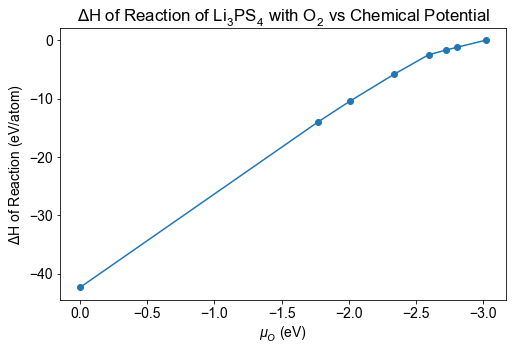

In [127]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot((LPS_cpe[0]), (LPS_cpe[2]), 'o', ls='-', label= r'S')

ax.invert_xaxis()
plt.title(r'$\Delta$H of Reaction of Li$_3$PS$_4$ with O$_2$ vs Chemical Potential')
plt.show()